In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('../data/processed/fight_data_cleaned.csv')

print("ONE PIECE FIGHT PREDICTOR - MODEL TRAINING")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['outcome'].value_counts()}")

ONE PIECE FIGHT PREDICTOR - MODEL TRAINING
Dataset shape: (4950, 46)
Target distribution:
outcome
victory    2849
loss       2027
draw         74
Name: count, dtype: int64


### Attribute Variants Analysis:
For each 1 core attribute (e.g., strength), we have 4 variants:
- fighter_1_strength (raw val for fighter 1)
- fighter_2_strength (raw val for fighter 2)
- strength_diff (fighter_1 - fighter_2)
- strength_advantage (1 if fighter_1 > fighter_2, else 0)

### Options:

1. Use ALL variants:
- **Pros**: maximum information
- **Cons**: redundancy, multicollinearity, overfitting risk

2. Use only DIFF variables:
- **Pros**: captures relative strength directly, less redundant
- **Cons**: loses absolute scale information (e.g., 10 - 8 is the same as 3 - 1)

3. Use only ADVANTAGE variables:
- **Pros**: simomple binary features, interpretable
- **Cons**: loses magnitude information 

4. Use DIFF + 1 raw value:
- **Pros**: relative comparison + absolute scale context
- **Cons**: still some redundancy

### Final Decision: Option 2
- **Fight prediction is inherently relative**: what matters is who's stronger, not absolute power levels
- **EDA**: _diff and _advantage variables had the highest correlations with outcome
- **Multicollinearity**: reduced significantly
- **Simpler model**: fewer features but same predictive power

### Proposed Feature Set: 
reaction_speed_diff, stamina_diff, strength_diff, offense_diff, defense_diff,combat_skills_diff, battle_iq_diff, armament_haki_diff, observation_haki_diff, conqueror_haki_diff, experience_diff

In [2]:
# Feature Selection: Use only DIFFERENCE variables
print("\nFEATURE SELECTION: DIFFERENCE VARIABLES ONLY")
print("=" * 50)

# Define the 11 core difference variables
diff_features = [
    'reaction_speed_diff',
    'stamina_diff', 
    'strength_diff',
    'offense_diff',
    'defense_diff',
    'combat_skills_diff',
    'battle_iq_diff',
    'armament_haki_diff',
    'observation_haki_diff',
    'conqueror_haki_diff',
    'experience_diff'
]

print(f"Selected difference features ({len(diff_features)}):")
for i, feature in enumerate(diff_features, 1):
    print(f"{i:2d}. {feature}")

# Check if all features exist in the dataset
missing_features = [f for f in diff_features if f not in df.columns]
if missing_features:
    print(f"\nMissing features: {missing_features}")
else:
    print(f"\nAll {len(diff_features)} features found in dataset")

# Update X with only the difference variables
X = df[diff_features]
y = df['outcome']

print(f"\nUpdated dataset:")
print(f"- Features: {X.shape[1]}")
print(f"- Samples: {X.shape[0]}")
print(f"- All numeric: {X.dtypes.apply(lambda x: x.name in ['int64', 'float64']).all()}")

# Quick correlation check with outcome
y_encoded_temp = LabelEncoder().fit_transform(y)
print(f"\nAll correlations with outcome:")
correlations = []
for feature in diff_features:
    corr = np.corrcoef(X[feature], y_encoded_temp)[0, 1]
    correlations.append((feature, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
for feature, corr in correlations:
    print(f"  {feature}: {corr:.3f}")


FEATURE SELECTION: DIFFERENCE VARIABLES ONLY
Selected difference features (11):
 1. reaction_speed_diff
 2. stamina_diff
 3. strength_diff
 4. offense_diff
 5. defense_diff
 6. combat_skills_diff
 7. battle_iq_diff
 8. armament_haki_diff
 9. observation_haki_diff
10. conqueror_haki_diff
11. experience_diff

All 11 features found in dataset

Updated dataset:
- Features: 11
- Samples: 4950
- All numeric: True

All correlations with outcome:
  strength_diff: 0.720
  reaction_speed_diff: 0.704
  stamina_diff: 0.701
  combat_skills_diff: 0.697
  offense_diff: 0.690
  defense_diff: 0.677
  armament_haki_diff: 0.676
  battle_iq_diff: 0.656
  experience_diff: 0.650
  observation_haki_diff: 0.626
  conqueror_haki_diff: 0.414


### Potential Solutions for the Conqueror's Haki dilemma

1. 2 Separate models:
- Approach: train 1 model for conqueror fights, 1 for non-conqueror fights
- Pros:
    - Captures true conqueror impact in relevant fights
    - Each model optimized for its specific context
- Cons:
    - Need to maintain 2 models
    - Conqueror model has limited training data
    - Deployment complexity (need to check whether fighters possess Conqueror first)

2. Feature Engineering:
- Approach: create interaction terms
    - **conqueror_present**: binary (1 if either fighter has it)
    - **conqueror_haki_diff** * **conqueror_present**: amplified difference when relevance
- Pros:
    - Single model
    - Captures conditional importance
- Cons:
    - More complex feature engineering
    - Model needs to learn the interaction

3. Stratified Approach:
- Approach: keep single model but weigh Conqueror fights more heavily during training
- Pros:
    - Single model
    - Emphasizes important cases
- Cons: may bias toward conqeuror scenarios

4. Ensemble Approach:
- Approach: train both specialized models + combine predictions
- Pros:
    - best of both worlds
    - can weigh predictions based on confidence
- Cons: most complex implementation

### Final Decision: Option 2 (Feature Engineering)
- **Practical deployment**: single model is easier to maintain
- **Data efficiency**: uses all data for training
- **Captures interaction**: model learns when conqueror matters
- **Interpretable**: clear features show the conditional effect

In [3]:
# Feature Engineering: Handle Conqueror's Haki interaction
print("\nFEATURE ENGINEERING: CONQUEROR'S HAKI INTERACTION")
print("=" * 60)

# Start with the base difference features (removing conqueror_haki_diff for now)
base_diff_features = [
    'reaction_speed_diff',
    'stamina_diff', 
    'strength_diff',
    'offense_diff',
    'defense_diff',
    'combat_skills_diff',
    'battle_iq_diff',
    'armament_haki_diff',
    'observation_haki_diff',
    'experience_diff'
]

# Create the engineered features
print("Creating Conqueror's Haki interaction features...")

# 1. conqueror_present: 1 if either fighter has Conqueror's Haki
df['conqueror_present'] = ((df['fighter_1_conqueror_haki'] > 0) | 
                          (df['fighter_2_conqueror_haki'] > 0)).astype(int)

# 2. conqueror_impact: amplified difference when relevant
df['conqueror_impact'] = df['conqueror_haki_diff'] * df['conqueror_present']

# Final feature set: 10 base + 2 engineered = 12 features
final_features = base_diff_features + ['conqueror_present', 'conqueror_impact']

print(f"\nFinal feature set ({len(final_features)} features):")
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")

# Update X with the engineered features
X = df[final_features]
y = df['outcome']

print(f"\nUpdated dataset:")
print(f"- Features: {X.shape[1]}")
print(f"- Samples: {X.shape[0]}")

# Analyze the new features
print(f"\nConqueror's Haki Feature Analysis:")
print(f"Fights with Conqueror present: {df['conqueror_present'].sum()}")
print(f"Percentage: {df['conqueror_present'].mean()*100:.1f}%")

print(f"\nConqueror impact statistics:")
print(f"- Mean: {df['conqueror_impact'].mean():.3f}")
print(f"- Std: {df['conqueror_impact'].std():.3f}")
print(f"- Non-zero values: {(df['conqueror_impact'] != 0).sum()}")

# Check correlations with the new features
y_encoded_temp = LabelEncoder().fit_transform(y)
correlations = []
for feature in final_features:
    corr = np.corrcoef(X[feature], y_encoded_temp)[0, 1]
    correlations.append((feature, abs(corr)))

correlations.sort(key=lambda x: x[1], reverse=True)
print(f"\nTop correlations with outcome (engineered features):")
for feature, corr in correlations:
    marker = "🔥" if "conqueror" in feature else "  "
    print(f"{marker} {feature}: {corr:.3f}")


FEATURE ENGINEERING: CONQUEROR'S HAKI INTERACTION
Creating Conqueror's Haki interaction features...

Final feature set (12 features):
 1. reaction_speed_diff
 2. stamina_diff
 3. strength_diff
 4. offense_diff
 5. defense_diff
 6. combat_skills_diff
 7. battle_iq_diff
 8. armament_haki_diff
 9. observation_haki_diff
10. experience_diff
11. conqueror_present
12. conqueror_impact

Updated dataset:
- Features: 12
- Samples: 4950

Conqueror's Haki Feature Analysis:
Fights with Conqueror present: 1464
Percentage: 29.6%

Conqueror impact statistics:
- Mean: 0.181
- Std: 0.489
- Non-zero values: 1344

Top correlations with outcome (engineered features):
   strength_diff: 0.720
   reaction_speed_diff: 0.704
   stamina_diff: 0.701
   combat_skills_diff: 0.697
   offense_diff: 0.690
   defense_diff: 0.677
   armament_haki_diff: 0.676
   battle_iq_diff: 0.656
   experience_diff: 0.650
   observation_haki_diff: 0.626
🔥 conqueror_impact: 0.414
🔥 conqueror_present: 0.224


In [4]:
# Verify the feature engineering is working
print("\nVERIFYING CONQUEROR'S HAKI FEATURE ENGINEERING")
print("=" * 60)

# Compare correlations in different fight types
conqueror_fights_mask = df['conqueror_present'] == 1
non_conqueror_fights_mask = df['conqueror_present'] == 0

print(f"Total fights: {len(df)}")
print(f"Conqueror fights: {conqueror_fights_mask.sum()}")
print(f"Non-Conqueror fights: {non_conqueror_fights_mask.sum()}")

# Correlations in Conqueror fights only
conqueror_fights = df[conqueror_fights_mask]
if len(conqueror_fights) > 0:
    y_conqueror = LabelEncoder().fit_transform(conqueror_fights['outcome'])
    
    # Original conqueror_haki_diff correlation
    corr_original = np.corrcoef(conqueror_fights['conqueror_haki_diff'], y_conqueror)[0, 1]
    
    # New conqueror_impact correlation (should be identical in these fights)
    corr_impact = np.corrcoef(conqueror_fights['conqueror_impact'], y_conqueror)[0, 1]
    
    print(f"\nCorrelations in CONQUEROR fights only:")
    print(f"  Original conqueror_haki_diff: {abs(corr_original):.3f}")
    print(f"  New conqueror_impact: {abs(corr_impact):.3f}")
    print(f"  Difference: {abs(corr_impact - corr_original):.6f} (should be ~0)")

# The key insight: Model can now learn the conditional relationship
print(f"\nTHE KEY INSIGHT:")
print(f"The model can now learn:")
print(f"- When conqueror_present = 1: conqueror_impact matters a lot")
print(f"- When conqueror_present = 0: conqueror_impact is always 0 (irrelevant)")
print(f"This is better than raw conqueror_haki_diff which was always 0 for most fights")


VERIFYING CONQUEROR'S HAKI FEATURE ENGINEERING
Total fights: 4950
Conqueror fights: 1464
Non-Conqueror fights: 3486

Correlations in CONQUEROR fights only:
  Original conqueror_haki_diff: 0.737
  New conqueror_impact: 0.737
  Difference: 0.000000 (should be ~0)

THE KEY INSIGHT:
The model can now learn:
- When conqueror_present = 1: conqueror_impact matters a lot
- When conqueror_present = 0: conqueror_impact is always 0 (irrelevant)
This is better than raw conqueror_haki_diff which was always 0 for most fights


In [5]:
from xgboost import XGBClassifier

# Model Training and Cross-Validation with Timing
print("\nMODEL TRAINING & CROSS-VALIDATION")
print("=" * 60)

import time

# First, let's prepare our final feature set and split the data
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Feature scaling (important for Logistic Regression and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {le.classes_}")

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

print(f"\n📋 Models to evaluate: {list(models.keys())}")

# Cross-validation results storage
cv_results = {}
model_objects = {}

print(f"\nCROSS-VALIDATION (5-fold) with Timing...")
print("-" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Determine if model needs scaled features
    if name in ['Logistic Regression', 'SVM']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Time the training
    train_start = time.time()
    model_fit = model.fit(X_cv, y_train)
    train_time = time.time() - train_start
    
    # Time the cross-validation
    cv_start = time.time()
    cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='accuracy')
    cv_time = time.time() - cv_start
    
    # Store results
    cv_results[name] = {
        'mean_score': cv_scores.mean(),
        'std_score': cv_scores.std(),
        'scores': cv_scores,
        'training_time': train_time,
        'validation_time': cv_time
    }
    model_objects[name] = model_fit
    
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Training Time: {train_time:.3f}s")
    print(f"  CV Time: {cv_time:.3f}s")

# Display results summary
print(f"\nCROSS-VALIDATION SUMMARY")
print("=" * 70)
print(f"{'Model':<20} {'CV Accuracy':<12} {'Std Dev':<8} {'Train Time':<10} {'CV Time':<8}")
print("-" * 70)

# Sort by CV score
sorted_results = sorted(cv_results.items(), key=lambda x: x[1]['mean_score'], reverse=True)

for name, results in sorted_results:
    mean_score = results['mean_score']
    std_score = results['std_score']
    train_time = results['training_time']
    cv_time = results['validation_time']
    print(f"{name:<20} {mean_score:.4f}      {std_score:.4f}   {train_time:.3f}s     {cv_time:.3f}s")

# Identify best model
best_model_name = sorted_results[0][0]
best_model = model_objects[best_model_name]
best_score = sorted_results[0][1]['mean_score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"Cross-validation accuracy: {best_score:.4f}")
print(f"Training time: {cv_results[best_model_name]['training_time']:.3f}s")


MODEL TRAINING & CROSS-VALIDATION
Training samples: 3960
Test samples: 990
Features: 12
Classes: ['draw' 'loss' 'victory']

📋 Models to evaluate: ['Logistic Regression', 'Random Forest', 'SVM', 'XGBoost']

CROSS-VALIDATION (5-fold) with Timing...
--------------------------------------------------

Training Logistic Regression...
  CV Accuracy: 0.9636 (+/- 0.0139)
  Training Time: 0.021s
  CV Time: 0.154s

Training Random Forest...
  CV Accuracy: 0.9634 (+/- 0.0115)
  Training Time: 0.500s
  CV Time: 2.187s

Training SVM...
  CV Accuracy: 0.9652 (+/- 0.0128)
  Training Time: 0.759s
  CV Time: 2.813s

Training XGBoost...
  CV Accuracy: 0.9621 (+/- 0.0111)
  Training Time: 0.321s
  CV Time: 1.256s

CROSS-VALIDATION SUMMARY
Model                CV Accuracy  Std Dev  Train Time CV Time 
----------------------------------------------------------------------
SVM                  0.9652      0.0064   0.759s     2.813s
Logistic Regression  0.9636      0.0069   0.021s     0.154s
Random Forest  


TEST SET EVALUATION - SVM
Test Accuracy: 0.9626

Classification Report:
               precision    recall  f1-score   support

   Class_draw       0.00      0.00      0.00        15
   Class_loss       0.96      0.97      0.97       405
Class_victory       0.97      0.98      0.97       570

     accuracy                           0.96       990
    macro avg       0.64      0.65      0.65       990
 weighted avg       0.95      0.96      0.96       990


Confusion Matrix:
[[  0   6   9]
 [  0 394  11]
 [  0  11 559]]


d:\one-piece-match-predictors\onepiecefightoutcome\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\one-piece-match-predictors\onepiecefightoutcome\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\one-piece-match-predictors\onepiecefightoutcome\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

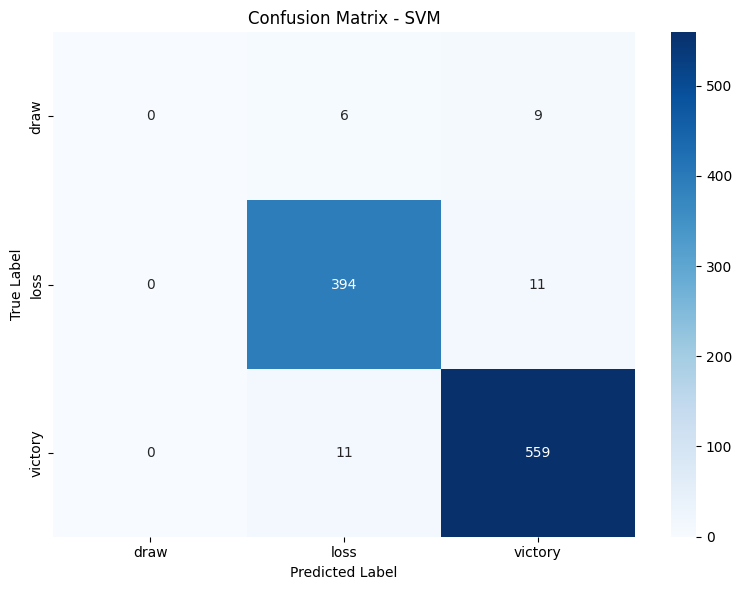


MODEL SELECTION COMPLETE!
Best performing model: SVM (Test Accuracy: 0.9626)


In [6]:
# Test set evaluation for the best model
print(f"\nTEST SET EVALUATION - {best_model_name}")
print("=" * 40)

# Use appropriate features for prediction
if best_model_name in ['Logistic Regression', 'SVM']:
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)
else:
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print(f"\nClassification Report:")
target_names = [f"Class_{cls}" for cls in le.classes_]
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nMODEL SELECTION COMPLETE!")
print(f"Best performing model: {best_model_name} (Test Accuracy: {test_accuracy:.4f})")